# Do climate targets enforce themselves via climate damages?
#### Christopher Callahan
#### Christopher.W.Callahan.GR@dartmouth.edu

#### Mechanics
Dependencies

In [1]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from scipy import stats

Data inputs

In [2]:
loc_ssp_iam = "../Data/SSP/"
loc_emissions = "../Data/GlobalCarbonBudget/"
loc_deflator = "../Data/GDPDeflator/" 

#### Parameters

TCRE

In [3]:
tcre = 0.48 # degrees C per 1000 GtCO2 of cumulative CO2 emissions

Time period

In [4]:
y1 = 2020
y2 = 2100
years = np.arange(y1,y2+1,1)

#### Functions

Function for loading SSP data and calculating quantities for Kaya Identity

In [5]:
def load_ssp_data(scenario,subset,mdl,years):
    # load data for desired variables, interpolate to yearly timestep
    
    var = ["Population","Emissions|CO2","GDP|PPP","Final Energy"]
    vname = ["population","emissions","gdp","energy"]

    # scenario name, load
    scenario_nm = scenario+"-"+subset
    data_in = pd.read_csv(loc_ssp_iam+"SSP_IAM_V2_201811.csv")
    data = data_in.loc[(data_in.SCENARIO==scenario_nm)&(data_in.REGION=="World")&(data_in.MODEL==mdl),:]
    
    # build dataframe
    df_orig = pd.DataFrame({"year":years,"population":np.full(len(years),np.nan),
                  "gdp":np.full(len(years),np.nan),"energy":np.full(len(years),np.nan),
                  "emissions":np.full(len(years),np.nan)})
    
    # load each variable
    for v in var:
        vn = vname[var.index(v)]
        data_v = data.loc[data.VARIABLE.values==v,:]
        yrs_v = data_v.iloc[:,7:].columns.values.astype(int) # index 7 because 2020
        data_v_vals = data_v.iloc[:,7:].values[0] # index 7 because 2020
        df_ind = [x in yrs_v for x in df_orig.year.values]
        df_orig.loc[df_ind,vn] = data_v_vals
    
    # convert US 2005 to US 2020
    gdp_deflator = pd.read_csv(loc_deflator+"API_NY.GDP.DEFL.ZS_DS2_en_excel_v2_4353530.csv")
    usa_deflator = gdp_deflator.loc[gdp_deflator["Country Code"]=="USA",:]
    deflator_2020_2005 = usa_deflator.loc[:,"2020"].values[0]/usa_deflator.loc[:,"2005"].values[0]
    df_orig["gdp"] = df_orig.gdp.values*deflator_2020_2005
    
    # Interpolate to yearly time step linearly
    df = df_orig.interpolate(method="polynomial",axis=0,order=2)
    
    # unit conversion
    df["emissions"] = df["emissions"]/1000.0 # mt co2/yr to gt co2/yr
    df["gdp"] = df["gdp"]/1000.0 # billion 2005 to trillion 2005
    df["population"] = df["population"]/1000.0 # million to billion
    
    # GDP growth
    df["gdp_growth"] = df.gdp.diff()/df.gdp.shift(periods=1)
    
    # kaya identity values
    df["e_g"] = df["energy"]/df["gdp"]
    df["f_e"] = df["emissions"]/df["energy"]
    df["g_p"] = df["gdp"]/df["population"]
    df["emissions_kaya"] = df.population * df.g_p * df.e_g * df.f_e
    
    return(df)

Main code for model

In [26]:
def run_model(years,initial_gdp,initial_emissions,initial_dt,
              tcre,damage_coefs,pop_list,e_g_list,f_e_list,growth_list):
    
    # years: time over to which to run model
    # initial_gdp: world GDP in 2020 in trillions USD
    # initial_emissions: *cumulative* emissions in 2020 in GtCO2
    # initial_dt: temperature change relative to pre-industrial in 2020
    # tcre: transient climate response to cumulative emissions in degrees C per 1000 GtCO2 cumulative
    # damage_coefs: damage function coefficients, in a list: intercept, linear, quadratic
    # pop_list: exogenous population over the years desired
    # e_g_list: exogenous energy intensity of GDP 
    # f_e_list: exogenous emissions intensity of energy (but can be modified by mitigation)
    # growth_list: exogenous baseline (non-damaged) rate of economic growth
    
    # requires xarray, numpy, sys
        
    gdp_out = xr.DataArray(np.full(len(years),np.nan),coords=[years],dims=["time"])
    emissions_out = xr.DataArray(np.full(len(years),np.nan),coords=[years],dims=["time"])
    deltat_out = xr.DataArray(np.full(len(years),np.nan),coords=[years],dims=["time"])
    
    gdp_out[0] = initial_gdp
    emissions_out[0] = initial_emissions
    deltat_out[0] = initial_dt
    
    # damage function coefs
    # in percents -- 2% should be in damage_coefs as 2, not 0.02
    coef0 = damage_coefs[0]/100.0
    coef1 = damage_coefs[1]/100.0
    coef2 = damage_coefs[2]/100.0
    
    for i in np.arange(1,len(years),1):
        year = years[i]

        # exogenous vals 
        pop = pop_list[i]
        e_g = e_g_list[i]
        f_e = f_e_list[i]
        gr = growth_list[i]

        # iterate
        gdp_nodamage = gdp_out[i-1] + (gdp_out[i-1]*gr)
        
        # take cumulative emissions from the previous year as the tcre input to year t
        emissions_prev = emissions_out[i-1] # for input to tcre
        
        # calculate delta t
        deltat_out[i] = emissions_prev*(tcre/1000.0)
        
        # damages to growth rate in percent
        damages = coef2*(deltat_out[i]**2) + (coef1*deltat_out[i]) + coef0
        
        # gdp with damages
        gdp_out[i] = gdp_out[i-1] + (gdp_out[i-1]*(gr-damages))
        
        # *cumulative* emissions as a result of gdp
        emissions_out[i] = (pop * (gdp_out[i]/pop) * (e_g) * (f_e)) + emissions_out[i-1]
        
    return([gdp_out,emissions_out,deltat_out])

#### Analysis

Load Global Carbon Budget data so we have cumulative emissions from 1850

In [22]:
gcp = pd.read_csv(loc_emissions+"GlobalCarbonBudget_HistoricalEmissions.csv")
gcp = gcp.loc[gcp.Year>=1850,:].reset_index().drop(columns="index")
gcp["total_emissions_gtc"] = gcp["fossil emissions excluding carbonation GtC"] + gcp["land-use change emissions GtC"]
gcp["total_emissions_gtco2"] = gcp.total_emissions_gtc*3.664
gcp["cumulative_emissions_gtco2"] = np.cumsum(gcp.total_emissions_gtco2.values)
gcp["obs_temp_change"] = gcp.cumulative_emissions_gtco2.shift(periods=1)/1000.0 * tcre

Now load SSP data for desired scenario

In [23]:
main_scenario = "SSP2"
scenario_subset = "Baseline" #Baseline, 19 for SSP1-19, 26 for SSP2-26, etc.
benchmark_mdls = {"SSP1":"IMAGE","SSP2":"MESSAGE-GLOBIOM",
                 "SSP3":"AIM/CGE","SSP4":"GCAM4","SSP5":"REMIND-MAGPIE"}
main_mdl = benchmark_mdls[main_scenario]
data_main = load_ssp_data(main_scenario,scenario_subset,main_mdl,np.arange(y1,y2+1,1))

Add cumulative emissions and temperature based on the GCP data

In [24]:
data_main["cumulative_emissions"] = np.cumsum(data_main["emissions"]) + gcp.loc[gcp.Year==(y1-1),"cumulative_emissions_gtco2"].values
data_main["dt"] = data_main.cumulative_emissions/1000.0 * tcre

Now simulate a range of damage fractions

In [43]:
damage_coefs_0 = 0 # no intercept
damage_coefs_1 = np.array([np.around(x,2) for x in np.arange(0,1.2+0.05,0.05)])
damage_coefs_2 = 0 # quadratic
# using approximate values from Moore and Diaz (2015) 
# which calibrate DICE to the growht effects found by Dell, Jones, and Olken (2012)
# damages are expressed as percentage-point changes in growth
# as a function of temperature
# https://www.nature.com/articles/nclimate2481
# https://scholar.harvard.edu/files/dell/files/aej_temperature.pdf

In [28]:
gdp_simulated = xr.DataArray(np.full((len(years),len(damage_coefs_1)),np.nan),
                          coords=[years,damage_coefs_1],
                         dims=["time","damages"])
emissions_simulated = xr.DataArray(np.full((len(years),len(damage_coefs_1)),np.nan),
                          coords=[years,damage_coefs_1],
                         dims=["time","damages"])
temp_simulated = xr.DataArray(np.full((len(years),len(damage_coefs_1)),np.nan),
                          coords=[years,damage_coefs_1],
                         dims=["time","damages"])
gdp_init = data_main.loc[data_main.year==y1,"gdp"].values[0]
emiss_init = data_main.loc[data_main.year==y1,"cumulative_emissions"].values[0]
t_init = data_main.loc[data_main.year==y1,"dt"].values[0]

for d in damage_coefs_1:
    print(d)
    gdp_simulated.loc[:,d], emissions_simulated.loc[:,d], temp_simulated.loc[:,d] = run_model(
                                                years,gdp_init,emiss_init,
                                                t_init,tcre,[damage_coefs_0,d,damage_coefs_2],
                                                data_main.population.values,data_main.e_g.values,
                                                data_main.f_e.values,data_main.gdp_growth.values)

0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
1.0
1.05
1.1
1.15
1.2


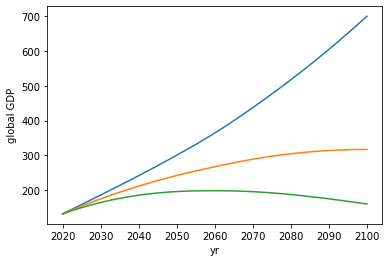

In [37]:
plt.plot(years,gdp_simulated.loc[:,0],label='no damage')
plt.plot(years,gdp_simulated.loc[:,0.5],label='0.5 pp per $\degree$C')
plt.plot(years,gdp_simulated.loc[:,1],label='1 pp per $\degree$C')
plt.xlabel("yr")
plt.ylabel("global GDP")
plt.show()

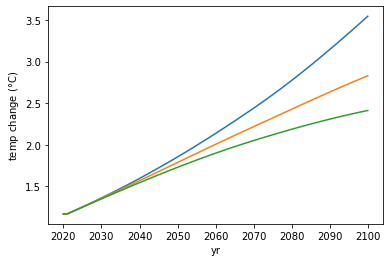

In [39]:
plt.plot(years,temp_simulated.loc[:,0],label='no damage')
plt.plot(years,temp_simulated.loc[:,0.5],label='0.5 pp per $\degree$C')
plt.plot(years,temp_simulated.loc[:,1],label='1 pp per $\degree$C')
plt.xlabel("yr")
plt.ylabel("temp change ($\degree$C)")
plt.show()

Run analysis for all SSPs

In [40]:
scenarios = ["SSP1","SSP2","SSP3","SSP4","SSP5"]
gdp_simulated_ssps = xr.DataArray(np.full((len(scenarios),len(years),len(damage_coefs_1)),np.nan),
                              coords=[scenarios,years,damage_coefs_1],
                                   dims=["scenario","time","damages"])
emissions_simulated_ssps = xr.DataArray(np.full((len(scenarios),len(years),len(damage_coefs_1)),np.nan),
                              coords=[scenarios,years,damage_coefs_1],
                                   dims=["scenario","time","damages"])
temp_simulated_ssps = xr.DataArray(np.full((len(scenarios),len(years),len(damage_coefs_1)),np.nan),
                              coords=[scenarios,years,damage_coefs_1],
                                   dims=["scenario","time","damages"])
gdp_main_ssps = xr.DataArray(np.full((len(scenarios),len(years)),np.nan),
                            coords=[scenarios,years],dims=["scenario","time"])
for s in scenarios:
    print(s)
    mdl = benchmark_mdls[s]
    data_s = load_ssp_data(s,"Baseline",mdl,years)
    data_s["cumulative_emissions"] = np.cumsum(data_s["emissions"]) + gcp.loc[gcp.Year==(y1-1),"cumulative_emissions_gtco2"].values
    data_s["dt"] = data_s.cumulative_emissions/1000.0 * tcre
    
    gdp_init = data_s.loc[data_s.year==y1,"gdp"].values[0]
    emiss_init = data_s.loc[data_s.year==y1,"cumulative_emissions"].values[0]
    t_init = data_s.loc[data_s.year==y1,"dt"].values[0]
    gdp_main_ssps.loc[s,:] = data_s.gdp.values
    
    for d in damage_coefs_1:
        gdp_simulated_ssps.loc[s,:,d], emissions_simulated_ssps.loc[s,:,d], temp_simulated_ssps.loc[s,:,d] = run_model(
                                            years,gdp_init,emiss_init,
                                            t_init,tcre,[damage_coefs_0,d,damage_coefs_2],
                                            data_s.population.values,data_s.e_g.values,
                                            data_s.f_e.values,data_s.gdp_growth.values)

SSP1
SSP2
SSP3
SSP4
SSP5


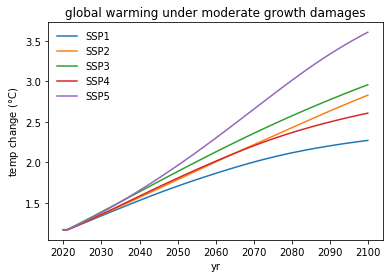

In [42]:
plt.plot(years,temp_simulated_ssps.loc["SSP1",:,0.5],label="SSP1")
plt.plot(years,temp_simulated_ssps.loc["SSP2",:,0.5],label="SSP2")
plt.plot(years,temp_simulated_ssps.loc["SSP3",:,0.5],label="SSP3")
plt.plot(years,temp_simulated_ssps.loc["SSP4",:,0.5],label="SSP4")
plt.plot(years,temp_simulated_ssps.loc["SSP5",:,0.5],label='SSP5')
plt.legend(loc="upper left",frameon=False)
plt.xlabel("yr")
plt.ylabel("temp change ($\degree$C)")
plt.title("global warming under moderate growth damages")
plt.show()